In [1]:
import os
import numpy as np
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from scipy.stats import mode
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [2]:

# Step 1: Data Preparation
data_dir = 'C:/Users/Dedu/Desktop/Research work/Neuro Marketing/Data-EEG-25-users-Neuromarketing/'  # Replace with the actual path to your data directory
users_dir = os.path.join(data_dir, '25-users')
labels_dir = os.path.join(data_dir, 'labels')

text_files = sorted([f for f in os.listdir(users_dir) if f.endswith('.txt')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.lab')])

features = []
labels = []

for text_file, label_file in zip(text_files, label_files):
    text_path = os.path.join(users_dir, text_file)
    label_path = os.path.join(labels_dir, label_file)

    # Load text file and extract features
    with open(text_path, 'r') as f:
        text_data = f.read()
    # Extract features from text_data and store them in the features list
    # Apply PSD feature extraction
    freq, psd = welch(np.fromstring(text_data, dtype=float, sep='\n'), fs=1.0)
    extracted_features = psd.mean(axis=0)  # Example: Taking the mean of PSD values as features
    features.append(extracted_features)

    # Load label file and assign labels
    with open(label_path, 'r') as f:
        label_data = f.read()
    # Assign labels based on label_data and store them in the labels list
    labels.append(label_data)
    

In [3]:
# Convert features and labels to numpy arrays
X = np.array(features)
y = np.array(labels)


In [4]:
# Reshape X to 2D array
X = X.reshape(-1, 1)

In [5]:
X

array([[61478.90540493],
       [ 1532.72805794],
       [ 1906.56126393],
       ...,
       [52854.01124456],
       [11864.17379572],
       [ 2813.00104159]])

In [6]:

# Convert the array to a DataFrame
column_names = ["features_data"]  # Replace with your actual feature names
df = pd.DataFrame(X, columns=column_names)

# Now your data is in the form of a DataFrame
print(df)


      features_data
0      61478.905405
1       1532.728058
2       1906.561264
3       1960.869490
4       1994.285424
...             ...
1040    3104.764774
1041    2804.372477
1042   52854.011245
1043   11864.173796
1044    2813.001042

[1045 rows x 1 columns]


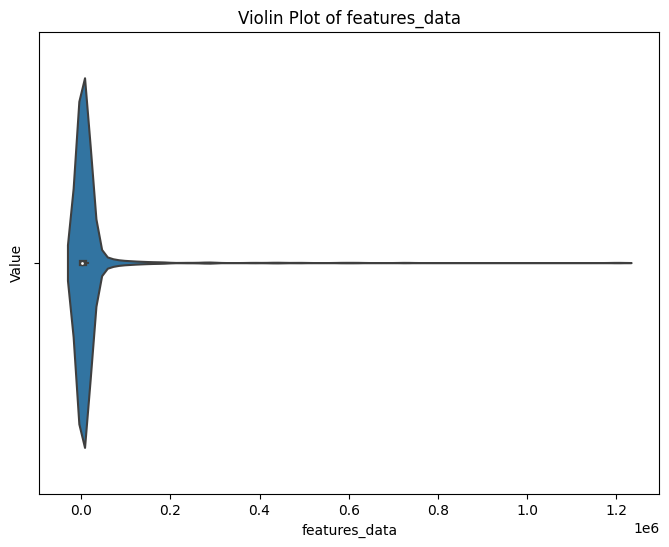

In [7]:
# Create a violin plot using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.violinplot(x=df["features_data"])

# Set plot labels and title
plt.xlabel("features_data")
plt.ylabel("Value")
plt.title("Violin Plot of features_data")

# Display the plot
plt.show()


In [8]:
# Reshape X to 2D array
X = X.reshape(-1, 1)
X

array([[61478.90540493],
       [ 1532.72805794],
       [ 1906.56126393],
       ...,
       [52854.01124456],
       [11864.17379572],
       [ 2813.00104159]])

In [9]:
# Step 2: Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)



In [10]:
y_resampled

array(['Like', 'Disike', 'Disike', ..., 'Like', 'Like', 'Like'],
      dtype='<U6')

In [11]:
# Step 3: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)



In [12]:
# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [13]:
# Step 5: Apply PCA for dimensionality reduction
n_components = 1  # Specify the number of components for PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [14]:
# Custom RBF Layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, centers, widths, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.centers = centers
        self.widths = widths

    def call(self, inputs):
        distance = tf.norm(inputs[:, tf.newaxis] - self.centers, axis=2)
        return tf.exp(-tf.square(distance) / (2 * tf.square(self.widths)))



In [15]:
# deep descion tree classifier

# Create decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Create multi-layer perceptron (neural network) classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Combine classifiers in a voting ensemble (deep neural decision forest)
voting_classifier = VotingClassifier(estimators=[('tree', decision_tree), ('mlp', mlp)], voting='soft')


In [16]:
# Step 6: Classification
tf.config.experimental_run_functions_eagerly(True)
cascade_models = []
cascade_train_data = X_train_pca
cascade_train_labels = y_train
print(cascade_train_labels)
num_centers = 10
centers = np.random.uniform(np.min(cascade_train_data), np.max(cascade_train_data), size=(num_centers, cascade_train_data.shape[1])).astype(np.float32)
widths = np.ones(num_centers, dtype=np.float32) * 0.5  # Adjust as needed

# RBF Model with Custom Layer
input_layer = tf.keras.layers.Input(shape=(cascade_train_data.shape[1],))
rbf_output = RBFLayer(centers, widths)(input_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(rbf_output)

rbf_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
rbf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

base_models = [
    GradientBoostingClassifier(n_estimators=100, max_depth=3),
    SVC(),
    DecisionTreeClassifier(),
    rbf_model,
    voting_classifier
]


for model in base_models:
    model.fit(cascade_train_data, cascade_train_labels)
    cascade_models.append(model)
    print(str(model)+ "training done ")
    cascade_train_pred = model.predict(cascade_train_data)
    print(str(model)+ "prediction done")
    misclassified_indices = np.where(cascade_train_pred != cascade_train_labels)[0]
    misclassified_indices = misclassified_indices % len(X_train)

    cascade_train_data = np.concatenate([cascade_train_data, X_train_pca[misclassified_indices]])
    cascade_train_labels = np.concatenate([cascade_train_labels, y_train[misclassified_indices]])




Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
[1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0
 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1
 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1
 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1
 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0
 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1
 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 

C:\Users\Dedu\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


55/55 [==============================] - 1s 21ms/step - loss: 0.6922 - accuracy: 0.5512
<keras.engine.functional.Functional object at 0x000002157B1C7F40>training done 
55/55 [==============================] - 0s 4ms/step
<keras.engine.functional.Functional object at 0x000002157B1C7F40>prediction done
VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(max_iter=1000, random_state=42))],
                 voting='soft')training done 
VotingClassifier(estimators=[('tree', DecisionTreeClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(max_iter=1000, random_state=42))],
                 voting='soft')prediction done


In [17]:

def cascade_predict(X):
    predictions = []
    for model in cascade_models:
        pr=model.predict(X)
        threshold = 0.5
        pr  = [1 if prob >= threshold else 0 for prob in pr]
        predictions.append(pr)
        print(str(model)+"prediction done")
        print(predictions)
        
    predictions = np.asarray(predictions)

    # Convert predictions to integers
    label_encoder = LabelEncoder()
    encoded_predictions = label_encoder.fit_transform(predictions.flatten())

    # Reshape the predictions array
    encoded_predictions_reshaped = np.reshape(encoded_predictions, (predictions.shape[0], predictions.shape[1]))

    # Perform majority voting
    majority_votes = mode(encoded_predictions_reshaped, axis=0).mode.flatten()

    return majority_votes




In [18]:
# Evaluate the performance of your cascade model on test data
y_pred = cascade_predict(X_test_pca)

# Convert predicted labels to binary class labels
threshold = 0.5
y_pred_labels = np.where(y_pred >= threshold, 'Like', 'Dislike')



GradientBoostingClassifier()prediction done
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]]
SVC()prediction done
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 

C:\Users\Dedu\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<keras.engine.functional.Functional object at 0x000002157B1C7F40>prediction done
[[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

C:\Users\Dedu\AppData\Local\Temp\ipykernel_21404\1066832630.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_votes = mode(encoded_predictions_reshaped, axis=0).mode.flatten()


In [19]:
# Calculate F1 score and accuracy for each model
f1_scores = []
accuracies = []

for model in cascade_models:
    y_pred_model = model.predict(X_test_pca)
    threshold = 0.5
    y_pred_model = [1 if prob >= threshold else 0 for prob in y_pred_model]
    f1 = f1_score(y_test, y_pred_model, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_model)
    f1_scores.append(f1)
    accuracies.append(accuracy)

# Print the F1 scores and accuracies for each model
for i, model in enumerate(cascade_models):
    print(f"Model {i+1} - F1 Score: {f1_scores[i]}, Accuracy: {accuracies[i]}")


C:\Users\Dedu\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 0s 20ms/step
Model 1 - F1 Score: 0.515441167843474, Accuracy: 0.5170940170940171
Model 2 - F1 Score: 0.344879489103045, Accuracy: 0.49572649572649574
Model 3 - F1 Score: 0.5162907479612837, Accuracy: 0.5170940170940171
Model 4 - F1 Score: 0.3476749239461104, Accuracy: 0.5128205128205128
Model 5 - F1 Score: 0.5162907479612837, Accuracy: 0.5170940170940171


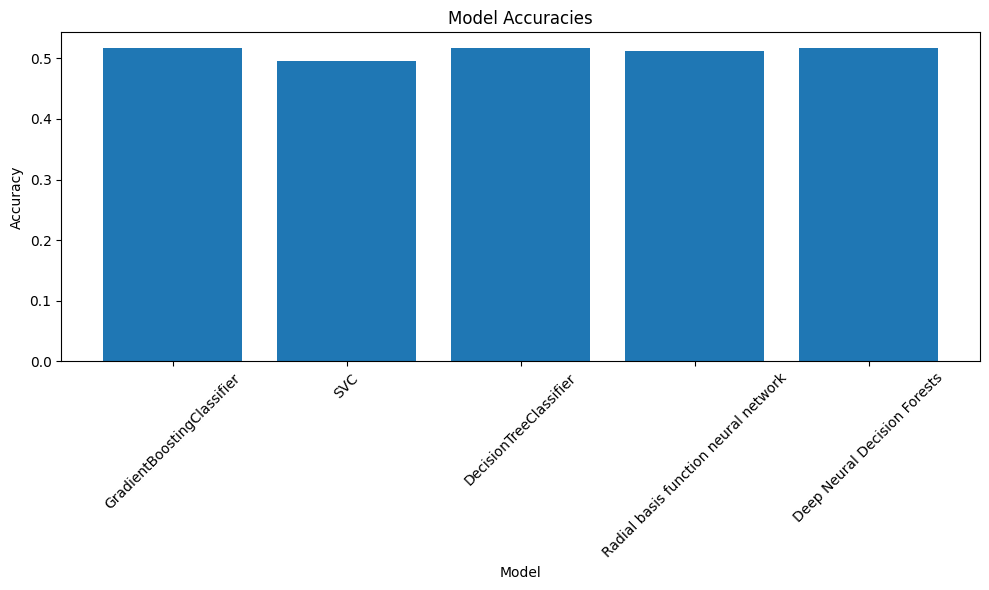

In [20]:
import matplotlib.pyplot as plt

# ... (your existing code to calculate f1_scores and accuracies) ...

# List of model names for the x-axis
model_names = ["GradientBoostingClassifier", "SVC", "DecisionTreeClassifier","Radial basis function neural network","Deep Neural Decision Forests"]  # Replace with your actual model names

# Plot the Accuracies for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure area
plt.show()
